Capital estacionário (k*): 27.316
Consumo estacionário (c*): 3.943


C:\Users\Leo\AppData\Local\Temp\ipykernel_25280\3235877183.py:33: RuntimeWarning: invalid value encountered in scalar power
  c[t+1] = beta * (alpha * k[t+1]**(alpha - 1) + 1 - delta) * c[t]
C:\Users\Leo\AppData\Local\Temp\ipykernel_25280\3235877183.py:32: RuntimeWarning: invalid value encountered in scalar power
  k[t+1] = k[t]**alpha + (1-delta)*k[t] - c[t]


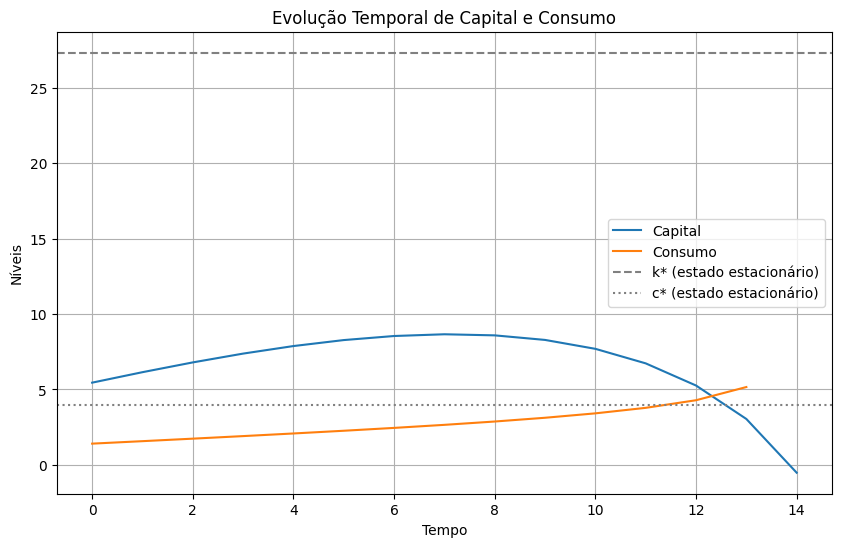

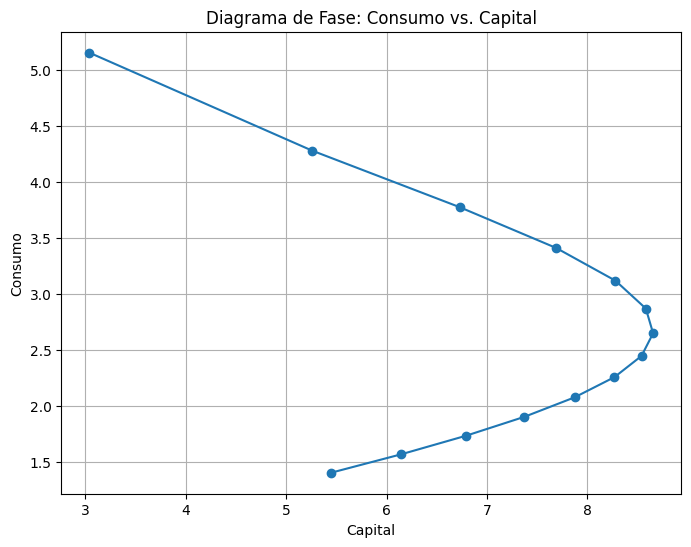

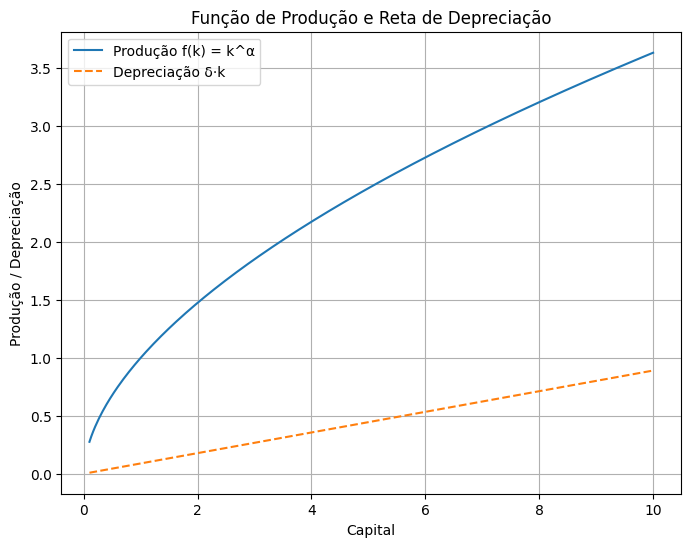

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do modelo
alpha = 0.56        # elasticidade da produção em relação ao capital
beta = 0.96         # fator de desconto
delta = 0.089        # taxa de depreciação
T = 10000            # número de períodos a simular

# Cálculo do estado estacionário (steady state)
# Na solução do Euler, o estado estacionário satisfaz: 1 = beta * (alpha * k_ss^(alpha-1) + 1 - delta)
# Portanto, k_ss = [alpha / (1/beta - (1-delta))]^(1/(1-alpha))
k_ss = (alpha / (1/beta - (1-delta)))**(1/(1-alpha))
# Consumo estacionário: usando a restrição de recursos no steady state:
c_ss = k_ss**alpha - delta * k_ss

print("Capital estacionário (k*): {:.3f}".format(k_ss))
print("Consumo estacionário (c*): {:.3f}".format(c_ss))

# Inicialização dos vetores para capital e consumo
k = np.zeros(T)
c = np.zeros(T)

# Condições iniciais (escolha de valores fora do steady state para ver a convergência)
k[0] = 5.447 # 2.0      # capital inicial
c[0] =  1.405 #  0.5      # consumo inicial (valor escolhido arbitrariamente)

# Sistema de equações:
# 1. Restrição de acumulação:  k[t+1] = f(k[t]) + (1-delta)*k[t] - c[t], com f(k)=k^alpha
# 2. Equação de Euler para log utilidade: c[t+1] = beta * (alpha * k[t+1]^(alpha-1) + 1-delta) * c[t]
for t in range(T-1):
    k[t+1] = k[t]**alpha + (1-delta)*k[t] - c[t]
    c[t+1] = beta * (alpha * k[t+1]**(alpha - 1) + 1 - delta) * c[t]

# Vetor tempo para os gráficos
time = np.arange(T)

# --- Gráfico 1: Evolução Temporal de Capital e Consumo ---
plt.figure(figsize=(10,6))
plt.plot(time, k, label="Capital")
plt.plot(time, c, label="Consumo")
plt.axhline(y=k_ss, color='gray', linestyle='--', label="k* (estado estacionário)")
plt.axhline(y=c_ss, color='gray', linestyle=':', label="c* (estado estacionário)")
plt.xlabel("Tempo")
plt.ylabel("Níveis")
plt.title("Evolução Temporal de Capital e Consumo")
plt.legend()
plt.grid(True)
plt.show()

# --- Gráfico 2: Diagrama de Fase (Consumo vs. Capital) ---
plt.figure(figsize=(8,6))
plt.plot(k, c, marker='o')
plt.xlabel("Capital")
plt.ylabel("Consumo")
plt.title("Diagrama de Fase: Consumo vs. Capital")
plt.grid(True)
plt.show()

# --- Gráfico 3: Função de Produção e Linha de Depreciação ---
# Para um conjunto de valores de k, plotamos f(k)=k^alpha e a reta delta*k.
k_vals = np.linspace(0.1, 10, 300)
f_k = k_vals**alpha         # função de produção
dep_line = delta * k_vals     # linha de depreciação

plt.figure(figsize=(8,6))
plt.plot(k_vals, f_k, label="Produção f(k) = k^α")
plt.plot(k_vals, dep_line, label="Depreciação δ·k", linestyle="--")
plt.xlabel("Capital")
plt.ylabel("Produção / Depreciação")
plt.title("Função de Produção e Reta de Depreciação")
plt.legend()
plt.grid(True)
plt.show()


Estado estacionário:
Capital (k*): 5.447
Consumo (c*): 1.405

Intervalo inicial para c0: [0.100, 1.265]
Consumo inicial ótimo encontrado (c0*): 0.798113


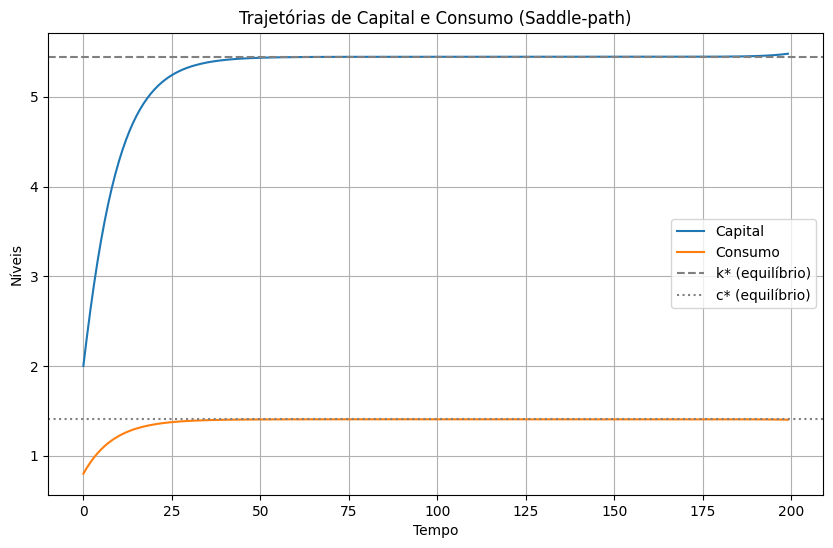

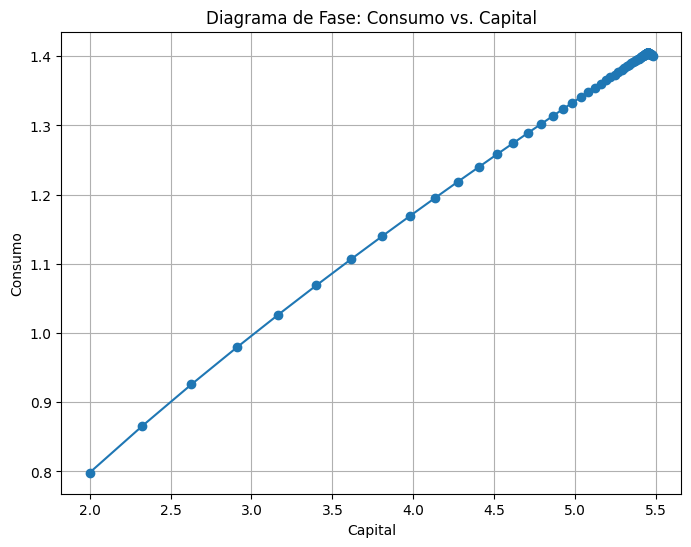

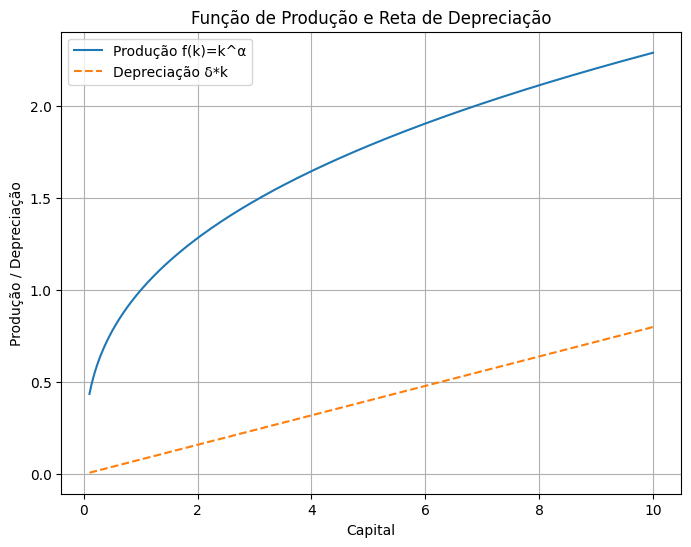

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do modelo
alpha = 0.36       # elasticidade da produção em relação ao capital
beta = 0.96        # fator de desconto
delta = 0.08       # taxa de depreciação
T = 200            # número de períodos da simulação
k0 = 2.0           # capital inicial

# Estado estacionário (k* e c*)
# k* = [alpha / (1/beta - (1-delta))]^(1/(1-alpha))
k_ss = (alpha / (1/beta - (1-delta)))**(1/(1-alpha))
# c* = f(k*) - delta*k* com f(k)= k^alpha
c_ss = k_ss**alpha - delta * k_ss

print("Estado estacionário:")
print("Capital (k*): {:.3f}".format(k_ss))
print("Consumo (c*): {:.3f}".format(c_ss))

# Função para simular a trajetória; se k ficar negativo, retorna NaN para penalizar essa trajetória
def simulate_path(c0, k0, T, alpha, beta, delta):
    k = np.zeros(T)
    c = np.zeros(T)
    k[0] = k0
    c[0] = c0
    for t in range(T-1):
        k_next = k[t]**alpha + (1-delta)*k[t] - c[t]
        # Se o capital ficar negativo, interrompe a simulação retornando NaN
        if k_next < 0:
            k[t+1:] = np.nan
            c[t+1:] = np.nan
            break
        k[t+1] = k_next
        # Para a equação de Euler: c[t+1] = beta*(alpha*k[t+1]^(alpha-1) + 1-delta)*c[t]
        c[t+1] = beta * (alpha * k[t+1]**(alpha-1) + 1-delta) * c[t]
    return k, c

# Função erro: diferença entre o capital final simulado e o estado estacionário
# Se a trajetória for inviável (NaN), retorna um valor negativo grande (penalidade)
def error_func(c0):
    k, _ = simulate_path(c0, k0, T, alpha, beta, delta)
    if np.isnan(k).any():
        return -1e10
    return k[-1] - k_ss

# Método de bisseção para encontrar o c0 ótimo (saddle-path)
def bisection_shooting(lower, upper, tol, max_iter):
    f_lower = error_func(lower)
    f_upper = error_func(upper)
    if f_lower * f_upper > 0:
        raise ValueError("Intervalo inválido para a bisseção: verifique os limites para c0.")
    for i in range(max_iter):
        mid = (lower + upper) / 2.0
        f_mid = error_func(mid)
        if abs(f_mid) < tol:
            return mid
        if f_lower * f_mid < 0:
            upper = mid
            f_upper = f_mid
        else:
            lower = mid
            f_lower = f_mid
    return mid

# Escolha dos limites para c0:
# Se k0 está abaixo de k*, o consumo ótimo deve ser menor que c* para permitir acumulação de capital.
# Ajuste os limites de acordo com a situação.
c0_lower = 0.1      # limite inferior (consumo bem baixo)
c0_upper = 0.9 * c_ss  # limite superior (menos que o consumo de equilíbrio)
print("\nIntervalo inicial para c0: [{:.3f}, {:.3f}]".format(c0_lower, c0_upper))

c0_star = bisection_shooting(c0_lower, c0_upper, tol=1e-6, max_iter=1000)
print("Consumo inicial ótimo encontrado (c0*): {:.6f}".format(c0_star))

# Simula a trajetória com c0 otimizado
k_path, c_path = simulate_path(c0_star, k0, T, alpha, beta, delta)

# Verifica se a trajetória é viável (sem capital negativo)
if np.isnan(k_path).any():
    print("A trajetória simulada se tornou inviável (capital negativo).")
else:
    # --- Gráfico 1: Evolução Temporal de Capital e Consumo ---
    time = np.arange(T)
    plt.figure(figsize=(10,6))
    plt.plot(time, k_path, label="Capital")
    plt.plot(time, c_path, label="Consumo")
    plt.axhline(y=k_ss, color='gray', linestyle='--', label="k* (equilíbrio)")
    plt.axhline(y=c_ss, color='gray', linestyle=':', label="c* (equilíbrio)")
    plt.xlabel("Tempo")
    plt.ylabel("Níveis")
    plt.title("Trajetórias de Capital e Consumo (Saddle-path)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Gráfico 2: Diagrama de Fase (Consumo vs. Capital) ---
    plt.figure(figsize=(8,6))
    plt.plot(k_path, c_path, marker='o')
    plt.xlabel("Capital")
    plt.ylabel("Consumo")
    plt.title("Diagrama de Fase: Consumo vs. Capital")
    plt.grid(True)
    plt.show()

    # --- Gráfico 3: Função de Produção vs. Linha de Depreciação ---
    k_vals = np.linspace(0.1, 10, 300)
    f_k = k_vals**alpha         # f(k) = k^alpha
    dep_line = delta * k_vals     # Linha de depreciação: δ*k

    plt.figure(figsize=(8,6))
    plt.plot(k_vals, f_k, label="Produção f(k)=k^α")
    plt.plot(k_vals, dep_line, label="Depreciação δ*k", linestyle="--")
    plt.xlabel("Capital")
    plt.ylabel("Produção / Depreciação")
    plt.title("Função de Produção e Reta de Depreciação")
    plt.legend()
    plt.grid(True)
    plt.show()
